# Sampling rate
Test the ctapipe image extractor for cameras with different sampling rate

In [1]:
paths = {
    #"chec": "/Users/Jason/Downloads/tempdata/obs/run1.simtel.gz",
    "nectar1000MHz": "/Users/Jason/Downloads/tempdata/sampling_rate/nectarcam_46.71pe_sample1000MHz.simtel.gz",
    "nectar500MHz": "/Users/Jason/Downloads/tempdata/sampling_rate/nectarcam_46.71pe_sample500MHz.simtel.gz",
    #"nectar_+start": "/Users/Jason/Downloads/tempdata/sampling_rate/nectarcam_46.71pe_sample1000MHz_longpulse1.simtel.gz",
    #"nectar_+end": "/Users/Jason/Downloads/tempdata/sampling_rate/nectarcam_46.71pe_sample1000MHz_longpulse2.simtel.gz",
    #"nectar_+start2": "/Users/Jason/Downloads/tempdata/sampling_rate/nectarcam_46.71pe_sample1000MHz_longpulse1_2.simtel.gz",
    #"nectar_+end2": "/Users/Jason/Downloads/tempdata/sampling_rate/nectarcam_46.71pe_sample1000MHz_longpulse2_2.simtel.gz",
}

In [2]:
from ctapipe.io.simteleventsource import SimTelEventSource
from ctapipe.calib.camera import CameraCalibrator
import numpy as np
import pandas as pd

In [3]:
def extract_charge(path):
    source = SimTelEventSource(input_url=path, max_events=100)
    subarray = source.subarray
    sample_width = (1/subarray.tel[1].camera.readout.sampling_rate).to_value('ns')
    calibrator = CameraCalibrator(subarray=subarray)
    df_list = []
    for event in source:
        calibrator(event)
        telid = list(event.dl1.tel.keys())[0]
        extracted_charge = event.dl1.tel[telid].image# / sample_width
#         extracted_charge = event.dl0.tel[telid].waveform.max(1)# / sample_width
        true_charge = event.mc.tel[telid].true_image
        df_list.append(pd.DataFrame({
                'iev': event.count,
                'ipix': np.arange(true_charge.size),
                'true': true_charge,
                'extracted': extracted_charge,
        }))
    df = pd.concat(df_list)
    df = df.loc[df['true'] < 100] # Ignore saturation for this investigation
    print(calibrator.image_extractor._calculate_correction(1))
    print(sample_width)
    return df

## Charge Distribution

In [4]:
dfs = {key: extract_charge(path) for key, path in paths.items()}

[0.94536953 0.94536881]
1.0
[0.89976411 0.89976436]
2.0


[0.90210461 2.24870723]
[0.9542941 2.3356137]


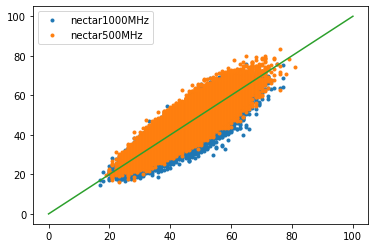

In [5]:
# Check charge distribution
from matplotlib import pyplot as plt
%matplotlib inline

for key, df in dfs.items():
    plt.plot(df['true'], df['extracted'], '.', label=key)
    print(np.polyfit(df['true'], df['extracted'], 1))
plt.legend(loc='best')
plt.plot([0, 100], [0, 100])

## Example Waveforms

MST_MST_NectarCam
0.10000000149011612 ns
1.0 GHz
MST_MST_NectarCam
0.20000000298023224 ns
0.5 GHz


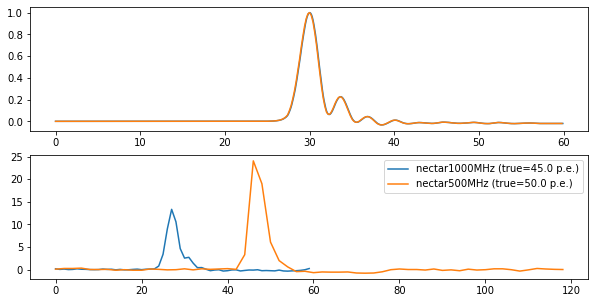

In [6]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
for key, path in paths.items():
    source = SimTelEventSource(input_url=path, max_events=100)
    subarray = source.subarray
    
    print(subarray.tel[1])
    reference_pulse_sample_width = subarray.tel[1].camera.readout.reference_pulse_sample_width.to_value('ns')
    reference_pulse_y = subarray.tel[1].camera.readout.reference_pulse_shape[0]
    ref_max_sample = reference_pulse_y.size * reference_pulse_sample_width
    reference_pulse_x = np.arange(0, ref_max_sample, reference_pulse_sample_width)    
    ax1.plot(reference_pulse_x, reference_pulse_y)
    print(subarray.tel[1].camera.readout.reference_pulse_sample_width)
    print(subarray.tel[1].camera.readout.sampling_rate)
    sample_width = (1/subarray.tel[1].camera.readout.sampling_rate).to_value('ns')
    for event in source:
        wf = event.r1.tel[1].waveform[0]
        true = event.mc.tel[1].true_image[0]
        x = np.arange(0, wf.size*sample_width, sample_width)
        ax2.plot(x, wf, label=f"{key} (true={true} p.e.)")
        break
    plt.legend(loc='best')